# Solving orbital equations with different algorithms

This notebook was adapted from `Orbit_games.ipynb`.



We consider energy plots and orbital solutions in polar coordinates for the general potential energy

$\begin{align}
   U(r) = k r^n
\end{align}$

for different ODE solution algorithms.  The `solve_ivp` function can itself be specified to use different solution methods (with the `method` keyword).  Here we will set it by default to use 'RK23', which is a variant on the Runge-Kutta second-order algorithm.  Second-order in this context means that the accuracy of a calculation will improve by a factor of $10^2 = 100$ if $\Delta t$ is reduced by a factor of ten. 

We will compare it with the crudest algorithm, Euler's method, which is first order, and a second-order algorithm called Leapfrog, which is designed to be precisely <em>time-reversal invariant</em>.  This property guarantees conservation of energy, which is not true of the other algorithms we will consider.

To solve the differential equations for orbits, we have defined the $\mathbf{y}$ 
and $d\mathbf{y}/dt$ vectors as

$\begin{align}
  \mathbf{y} = \left(\begin{array}{c} r(t) \\ \dot r(t) \\ \phi(t)  \end{array} \right) 
  \qquad
  \frac{d\mathbf{y}}{dt} 
       = \left(\begin{array}{c} \dot r(t) \\ \ddot r(t) \\ \dot\phi(t) \end{array} \right) 
       = \left(\begin{array}{c} \dot r(t) \\ 
                                 -\frac{1}{\mu}\frac{dU_{\rm eff}(r)}{dr} \\ 
                                 \frac{l}{\mu r^2} \end{array} \right) 
\end{align}$

where we have substituted the differential equations for $\ddot r$ and $\dot\phi$.

Then Euler's method can be written as a simple prescription to obtain $\mathbf{y}_{i+1}$ 
from $\mathbf{y}_i$, where the subscripts label the elements of the `t_pts` array: 
$\mathbf{y}_{i+1} = \mathbf{y}_i + \left(d\mathbf{y}/dt\right)_i \Delta t$, or, by components:

$\begin{align}
   r_{i+1} &= r_i + \frac{d\mathbf{y}_i[0]}{dt}  \Delta t  \\
   \dot r_{i+1} &= \dot r_{i} + \frac{d\mathbf{y}_i[1]}{dt}  \Delta t \\
   \phi_{i+1} &= \phi_i + \frac{d\mathbf{y}_i[2]}{dt} \Delta t
\end{align}$

**Look at the** `solve_ode_Euler` **method below and verify the algorithm is correctly implemented.** 

The leapfrog method does better by evaluating $\dot r$ at a halfway time step before and after the $r$ evaluation, 
which is both more accurate and incorporates time reversal: 

$\begin{align}
   \dot r_{i+1/2} &= \dot r_{i} + \frac{d\mathbf{y}_i[1]}{dt}  \Delta t/2 \\
   r_{i+1} &= r_i +  \dot r_{i+1/2}  \Delta t  \\
   \dot r_{i+1} &= \dot r_{i+1/2} + \frac{d\mathbf{y}_{i+1}[1]}{dt}  \Delta t/2 \\
   \phi_{i+1} &= \phi_i + \frac{d\mathbf{y}_i[2]}{dt} \Delta t
\end{align}$

**Look at the** `solve_ode_Leapfrog` **method below and verify the algorithm is correctly implemented.** 

A third method is the second-order Runge-Kutta algorithm, which we invoke from `solve_ivp` as `RK23`. 
It does not use a fixed time-step as in our "homemade" implementations, so there is not a direct 
comparison, but we can still check if it conserves energy.

**Run the notebook.  You are to turn in and comment on the "Change in energy with time" plot at the end.  
Where do you see energy conserved or not conserved?  Show that Euler is first order and leapfrog is second 
order by changing $\Delta t$; describe what you did and what you found.**

**Try another potential to see if you get the same general conclusions.**

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [66]:
# Change the common font size
font_size = 14
plt.rcParams.update({'font.size': font_size})

In [67]:
class Orbit:
    """
    Potentials and associated differential equations for central force motion
    with the potential U(r) = k r^n.  Several algorithms for integration of 
    ordinary differential equations are now available. 
    """
    
    def __init__(self, m1=1., m2=1., G=1.):
        self.m1 = m1
        self.m2 = m2
        self.G = G
        
    def dz_dt(self, t, z):
        """
        This function returns the rhs of the diffeq:
        [dz/dt d^2z/dt^2]
        """
        r_12 = np.sqrt((z[0] - z[4])**2 + (z[2] - z[6])**2)
        return [ \
                z[1], self.G * self.m2 * (z[4]-z[0]) / r_12**3, \
                z[3], self.G * self.m2 * (z[6]-z[2]) / r_12**3, \
                z[5], -self.G * self.m1 * (z[4]-z[0]) / r_12**3, \
                z[7], -self.G * self.m1 * (z[6]-z[2]) / r_12**3, \
               ]
    
    def solve_ode(self, t_pts, z_0,
                  abserr=1.0e-8, relerr=1.0e-8):
        """
        Solve the ODE given initial conditions.
        Use solve_ivp with the option of specifying the method.
        Specify smaller abserr and relerr to get more precision.
        """
        solution = solve_ivp(self.dz_dt, (t_pts[0], t_pts[-1]), 
                             z_0, t_eval=t_pts, method='RK23', 
                             atol=abserr, rtol=relerr)
        x1, x1dot, y1, y1dot, x2, x2dot, y2, y2dot = solution.y
        return x1, x1dot, y1, y1dot, x2, x2dot, y2, y2dot
    
    def solve_ode_Leapfrog(self, t_pts, r_0, r_dot_0, phi_0):
        """
        Solve the ODE given initial conditions with the Leapfrog method.
        """
        delta_t = t_pts[1] - t_pts[0]
        
        # initialize the arrays for r, rdot, r_dot_half, phi with zeros
        num_t_pts = len(t_pts)
        x1 = np.zeros(num_t_pts)
        x1dot = np.zeros(num_t_pts)
        x1dot_half = np.zeros(num_t_pts)
       
        
        y1 = np.zeros(num_t_pts)
        y1dot = np.zeros(num_t_pts)
        y1dot_half = np.zeros(num_t_pts)
        
        
        x2 = np.zeros(num_t_pts)
        x2dot = np.zeros(num_t_pts)
        x2dot_half = np.zeros(num_t_pts)
       
        
        y2 = np.zeros(num_t_pts)
        y2dot = np.zeros(num_t_pts)
        y2dot_half = np.zeros(num_t_pts)
        
        # initial conditions
        x1[0] = x10
        x1dot[0] = x1dot_0
        y1[0] = y10
        y1dot[0] = y1dot_0
        x2[0] = x20
        x2dot[0] = x2dot_0
        y2[0] = y20
        y2dot[0] = y2dot_0
        
        # step through the differential equation
        for i in np.arange(num_t_pts - 1):
            t = t_pts[i]
            
            z = x1[i], x1dot[i], y1[i], y1dot[i], x2[i], x2dot[i], y2[i], y2dot[i]
            out = self.dz_dt(t,z)
            
            x1dot_half[i] = x1dot[i+1] + out[1] * delta/2
            x1[i+1] = x1[i] + x1dot_half[i] * delta/2
            
            y1dot_half[i] = y1dot[i+1] + out[1] * delta/2
            y1[i+1] = y1[i] + y1dot_half[i] * delta/2
            
            x2dot_half[i] = x2dot[i+1] + out[1] * delta/2
            x2[i+1] = x2[i] + x2dot_half[i] * delta/2
            
            y2dot_half[i] = y2dot[i+1] + out[1] * delta/2
            y2[i+1] = y2[i] + y2dot_half[i] * delta/2
            
            z = x1[i+1], x1dot[i], y1[i+1], y1dot[i], x2[i+1], x2dot[i], y2[i+1], y2dot[i]
            out = self.dz_dt(t,z)
            
            x1dot[i+1] = x1dot_half[i] + out[1] * delta/2
            y1dot[i+1] = y1dot_half[i] + out[1] * delta/2
            x2dot[i+1] = x2dot_half[i] + out[1] * delta/2
            y2dot[i+1] = y2dot_half[i] + out[1] * delta/2
            
        return x1, x1dot, y1, y1dot, x2, x2dot, y2, y2dot
    
    
    def solve_ode_Leapfrog_n(self, t_pts, z_0):
        """
        Solve the ODE given initial conditions with the Leapfrog method.
        """
        delta_t = t_pts[1] - t_pts[0]
        
        x1, x1dot, y1, y1dot, x2, x2dot, y2, y2dot = z_0
        
        # initialize the arrays for r, rdot, r_dot_half, phi with zeros
        num_t_pts = len(t_pts)
        ntot = len(z_0)
        z = np.zeros(shape=(ntot, num_t_pts))
        dot_half = np.zeros(int (ntot/2))
        
        
        
        # initial conditions
        z[:0] = z_0
        
        # step through the differential equation
        for i in np.arange(num_t_pts - 1):
            t = t_pts[i]
            z_now = z[:i]
            out = np.asarray(self.dz_dt(t,z_now))
            dothalf = z_now[0::2] + out[1::2]* delta/2
            z[0::2, i+1] = z_now[0::2] + dothalf * delta
            z_now[0::2] = z[0::2,i+1]
            out = np.asarray(self.dz_dt(t,z_now))
            z[1::2, i+1] = dothalf + out[1::2] * delta/2
            
        return z
        
    
    def energy(self, t_pts, r, r_dot):
        """Evaluate the energy as a function of time"""
        return (self.mu/2.) * r_dot**2 + self.Ueff(r)  

In [68]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [69]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

## Make orbit plots

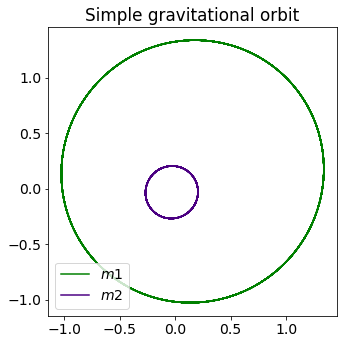

In [70]:
orbit_labels = (r'$x$', r'$y$')

# Plotting time 
t_start = 0.
t_end = 50.
delta_t = 0.01

t_pts = np.arange(t_start, t_end+delta_t, delta_t)

G = 1.
m1 = 1.
m2 = 5.

#Instantiate orbits
o1 = Orbit(m1, m2, G)

# Initial conditions with CoM velocity = 0
x1_0, x1dot_0 = 1., 1.
y1_0, y1dot_0 = 1., -1.
x2_0, x2dot_0 = -(m1/m2) * x1_0, -(m1/m2) * x1dot_0
y2_0, y2dot_0 = -(m1/m2) * y1_0, -(m1/m2) * y1dot_0

z_0 = [x1_0, x1dot_0, y1_0, y1dot_0, x2_0, x2dot_0, y2_0, y2dot_0]

x1, x1dot, y1, y1dot, x2, x2dot, y2, y2dot = o1.solve_ode(t_pts, z_0)

#Start plot
fig = plt.figure(figsize=(5,5))

#First plot - orbit
ax = fig.add_subplot(1,1,1)

start, stop = start_stop_indices(t_pts, t_start, t_end)
ax.plot(x1, y1, color='green', label=r'$m1$')
ax.plot(x2, y2, color='indigo', label=r'$m2$')
ax.set_title('Simple gravitational orbit')
ax.legend()
ax.set_aspect(1)

fig.tight_layout()
fig.savefig('simple_orbits.png', bbox_inches='tight')

# insert text explanation for part b

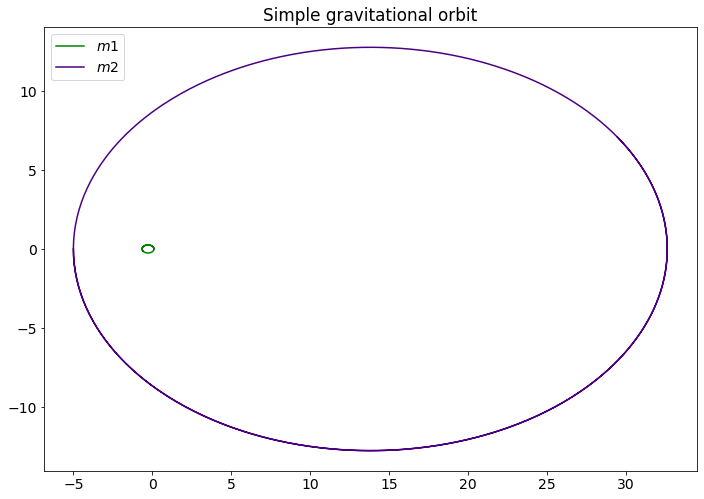

In [71]:
orbit_labels = (r'$x$', r'$y$')

# Plotting time 
t_start = 0.
t_end = 10.
delta_t = 0.01

t_pts = np.arange(t_start, t_end+delta_t, delta_t)

G = 150.
m1 = 50.
m2 = 1.

#Instantiate orbits
o1 = Orbit(m1, m2, G)

# Initial conditions with CoM velocity = 0
x1_0, x1dot_0 = 0.1, 0.
y1_0, y1dot_0 = 0., 1.
x2_0, x2dot_0 = -(m1/m2) * x1_0, -(m1/m2) * x1dot_0
y2_0, y2dot_0 = -(m1/m2) * y1_0, -(m1/m2) * y1dot_0

z_0 = [x1_0, x1dot_0, y1_0, y1dot_0, x2_0, x2dot_0, y2_0, y2dot_0]

x1, x1dot, y1, y1dot, x2, x2dot, y2, y2dot = o1.solve_ode(t_pts, z_0)

#Start plot
fig = plt.figure(figsize=(10,10))

#First plot - orbit
ax = fig.add_subplot(1,1,1)

start, stop = start_stop_indices(t_pts, t_start, t_end)
ax.plot(x1, y1, color='green', label=r'$m1$')
ax.plot(x2, y2, color='indigo', label=r'$m2$')
ax.set_title('Simple gravitational orbit')
ax.legend(loc='upper left')
ax.set_aspect(1)

fig.tight_layout()
fig.savefig('simple_orbits.png', bbox_inches='tight')

### When one of the orbiting masses is much larger than the other, it gets closer to the center of mass, and therefore has a much smaller orbit compared to the smaller mass. This is similar to how the heavy sun works in our solar system surrounded by the comparitively low-mass planets like Earth.

In [72]:
# Plotting time 
t_start = 0.
t_end = 50.
delta_t = 0.01

t_pts = np.arange(t_start, t_end+delta_t, delta_t)

G = 10.
m1 = 1.
m2 = 1.

#Instantiate orbits
o1 = Orbit(m1, m2, G)

# Initial conditions with CoM velocity = 0
x1_0, x1dot_0 = 1., 0.
y1_0, y1dot_0 = 0., 1.
x2_0, x2dot_0 = -(m1/m2) * x1_0, -(m1/m2) * x1dot_0
y2_0, y2dot_0 = -(m1/m2) * y1_0, -(m1/m2) * y1dot_0

z_0 = [x1_0, x1dot_0, y1_0, y1dot_0, x2_0, x2dot_0, y2_0, y2dot_0]

x1, x1dot, y1, y1dot, x2, x2dot, y2, y2dot = o1.solve_ode(t_pts, z_0)


In [73]:
from matplotlib import animation, rc
from IPython.display import HTML

In [74]:
%%capture

x_min = -2.5
x_max = -x_min
y_min = -2.5
y_max = -y_min

fig_anim = plt.figure(figsize=(5,5), num='Orbit animation')
ax_anim = fig_anim.add_subplot(1,1,1)
ax_anim.set_xlim(x_min, x_max)
ax_anim.set_ylim(y_min, y_max)

# By assigning the first return from plot to line_anim, we can later change
#  the values in the line.
ln1_anim, = ax_anim.plot(x1, y1, color='green', lw=1)
ln2_anim, = ax_anim.plot(x2, y2, color='indigo', lw=1)

pt1_anim, = ax_anim.plot(x1[0], y1[0], 'o', markersize=12, color='green')
pt2_anim, = ax_anim.plot(x2[0], y2[0], 'o', markersize=12, color='indigo')

ax_anim.set_aspect(1)
ax_anim.axis('off')
fig_anim.tight_layout()

In [75]:
def animate_orbits(i):
    """
    FuncAnimation frame indexer
    """
    i_skip = 1 * i
    
    pt1_anim.set_data(x1[i_skip], y1[i_skip])
    pt2_anim.set_data(x2[i_skip], y2[i_skip])
    
    return (pt1_anim, pt2_anim)

In [76]:
frame_interval = 10.
frame_number = 1001
anim = animation.FuncAnimation(fig_anim, 
                               animate_orbits, 
                               init_func=None, 
                               frames=frame_number, 
                               interval=frame_interval, 
                               blit=True, 
                               repeat=False)

In [77]:
HTML(anim.to_jshtml())